# Investigating Student Performance in Exams


## Dataset: Student Performance in Exams
https://www.kaggle.com/spscientist/students-performance-in-exams

This dataset is about student performance, where it lists the students' grades in 3 subjects, as well as information about the student, like their gender, ethnicity and whether they had supplementary courses 

The dataset contains 8 columns:
* `gender`: a categorical variable (male or female)
* `race/ethnicity`: a categorical variable, taking one of five values: `group A, group B...group E` 
* `parental level of education`: categorical variable, which can be `high school, college, bachelor's, master's or associate degress`
* `lunch`: a categorical variable, which tells the type of lunch the students have. This reflects their financial status. It can be `standard` or `free\reduced`
* `test preparation course`: indicates whether a student completed such course. The values can be either `completed` or `none`
* The rest of the columns are numeric, indicating the studen't's score, out of 100, in `math`, `reading` and `writing`

The dataset has **1000 records**

## Investigation Procedure
* I wanted to know what factors influence student perfromance in exams. <br>
* I also found that student performance varies with racial group. I extensively investigated to come up with explanation why something like that can happen.

# Univariate Exploration

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
base_color = sb.color_palette()[0]
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [32]:
df = pd.read_csv("dataset/StudentsPerformance.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## 2. Data wrangling
In this step, I will perform the following:
* checking the column names are "code friendly"
* checking for nulls in the data
* checking if there are duplicate rows
* checking if the datatypes are the most suitable for each column

This process is iterative, so I might need to do some data wrangling later

#### 2.1 Code friendly colum names
From the dataframe head, we can see that the column names are meaningful, but can sometimes be long or contain whitespace, which are not code friendly. As such, I will try to rename them

In [33]:
# replace column names with values in the dictionary
df_mod = df.rename(columns={
    "race/ethnicity":"race",
    "parental level of education": "parent_education",
    "test preparation course": "prep_course"
})

# replace whitespace with underscore
df_mod.rename(columns= lambda x: x.replace(" ", "_"), inplace = True)

df_mod.head()

,gender,race,parent_education,lunch,prep_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#### 2.2 Nulls, and datatypes
This can be easily checked by the `info()` method of the datafram

In [34]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            1000 non-null   object
 1   race              1000 non-null   object
 2   parent_education  1000 non-null   object
 3   lunch             1000 non-null   object
 4   prep_course       1000 non-null   object
 5   math_score        1000 non-null   int64 
 6   reading_score     1000 non-null   int64 
 7   writing_score     1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


So, 
* the data has no null values,
* The test scores are integers, and the categorical data is of type string

So far so good. **However**, for ordinal data, like parent_education. It will be useful to sort ordinal data while visualizing. We can do that via the `pd.api.CategoricalDatatype()` function to create an ordinal datatype, and convert the dataframe column to that datatype

###### Ordinal Datatype

In [35]:
# create a list of sorted data
sorted_edu_levels = ["some high school", "high school", "some college", "associate's degree",
                     "bachelor's degree", "master's degree"]
# create the oridnal datatype
parent_education_ordinal = pd.api.types.CategoricalDtype(categories=sorted_edu_levels,
                                                        ordered = True)
# cast to this new type
df_mod["parent_education"] = df_mod["parent_education"].astype(parent_education_ordinal)

The rest of the ordinal columns, like lunch or prep course, are binary anyways, so we do not need to convert them

#### 2.3 Duplicated rows

In [36]:
print("Are there any duplicated rows?")
df.duplicated().any()

Are there any duplicated rows?


False

That's it for data wrangling, unless something else comes up later

## Distribution of Math, reading and writing scores
Becuase score is an integer between [0 and 100], we can plot a histogram with binsize = 1. Or, to make the trend more visible, we can group the score into bins of 5

The scores resemble a Gaussian distribution, and skewed to the left, where the average grade lies in the range [60 to 80]

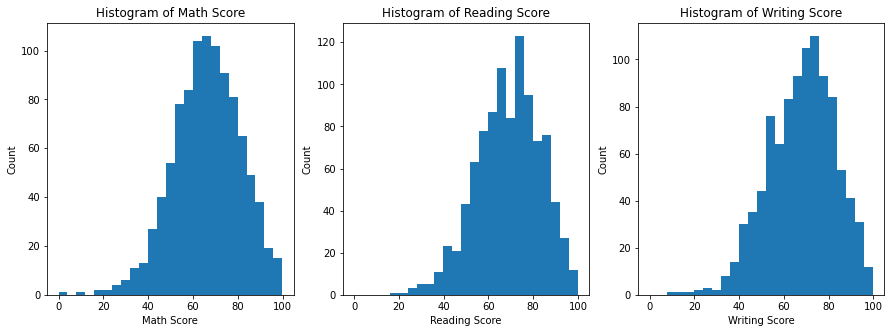

In [42]:
# bins of size 5 and include the range [0 -> 100]
bins = np.arange(start = 0, stop = 101, step = 4) - 0.1

plt.figure(figsize= (15,5));
# plot math score
plt.subplot(1,3,1);
plt.hist(data = df_mod, x = "math_score", bins = bins);
plt.xlabel("Math Score");
plt.ylabel("Count");
plt.title("Histogram of Math Score");

# plot reading score
plt.subplot(1,3,2);
plt.hist(data = df_mod, x = "reading_score", bins = bins);
plt.xlabel("Reading Score");

plt.ylabel("Count");
plt.title("Histogram of Reading Score");

# plot the writing score
plt.subplot(1,3,3);
plt.hist(data = df_mod, x = "writing_score", bins = bins);
plt.xlabel("Writing Score");
plt.ylabel("Count");
plt.title("Histogram of Writing Score");

## Score Redundant information?
It is obvious that any further analysis will be connected with the test scores. However, instead of analysing the effect of each factor with each score, we can summarize the test scores in 1 variable, if the scores are highly correlated **(feature engineering)**

In order to know that, we can use scatter plots of all scores against each other

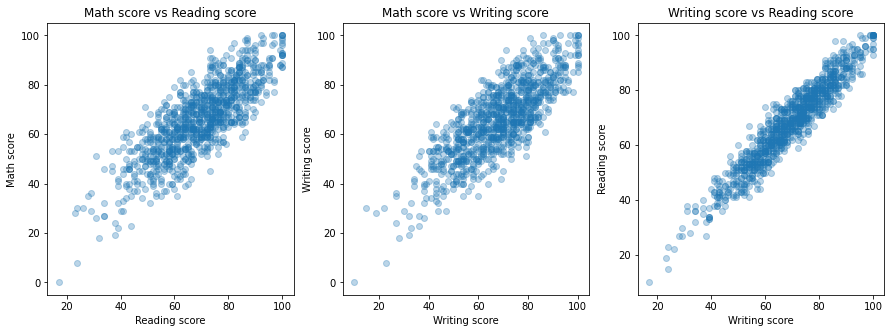

In [44]:
plt.figure(figsize=(15,5));
alpha = 0.3

# math score vs reading score
plt.subplot(1,3,1);
plt.scatter(y = df_mod.math_score, x = df_mod.reading_score, alpha = alpha);
plt.xlabel("Reading score");
plt.ylabel("Math score");
plt.title("Math score vs Reading score");

# math score vs writing score
plt.subplot(1,3,2);
plt.scatter(y = df_mod.math_score, x = df_mod.writing_score, alpha = alpha);
plt.xlabel("Writing score");
plt.ylabel("Writing score");
plt.title("Math score vs Writing score");

# writing score vs reading score
plt.subplot(1,3,3);
plt.scatter(y = df_mod.writing_score, x = df_mod.reading_score, alpha = alpha);
plt.xlabel("Writing score");
plt.ylabel("Reading score");
plt.title("Writing score vs Reading score");

* We can see that all test scores are **highly corrlated**, with reading and writing scores being the most correlated.
* We can use this observation to include a new feature, and eliminate some redundancy in the data
* We can create a new feature `avg_score` to be the average of the three scores
* However, because `reading` and `writing` are more correlated, we can make their weights less

In [45]:
# create new feature (weighted average of all scores)
df_mod["avg_score"] = 0.5 * df_mod.math_score + 0.25 * df_mod.writing_score + 0.25 * df_mod.reading_score

# drop the scores features
df_mod.drop(columns = ["math_score", "reading_score", "writing_score"], inplace = True)

# display the head
df_mod.head()

,gender,race,parent_education,lunch,prep_course,avg_score
0,female,group B,bachelor's degree,standard,none,72.50
1,female,group C,some college,standard,completed,79.00
2,female,group B,master's degree,standard,none,92.00
3,male,group A,associate's degree,free/reduced,none,48.75
4,male,group C,some college,standard,none,76.25


## Average Score vs Gender
The performace of females is slightly better, but with more outliers in the lower scores. The margin between the groups performances is too small however.

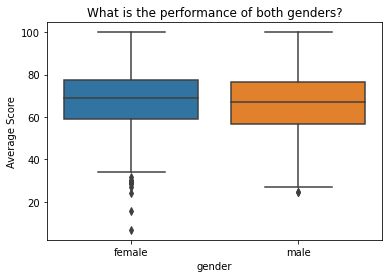

In [63]:
sb.boxplot(data = df_mod, x = "gender", y = "avg_score");
plt.ylabel("Average Score");
plt.title("What is the performance of both genders?");

## Average Test Score for different racial groups

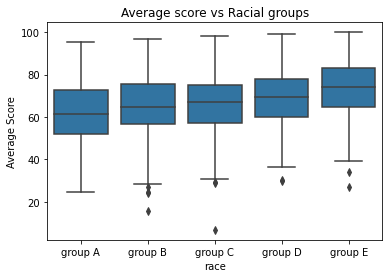

In [47]:
# find the order
order = df_mod.groupby("race").median().iloc[::1].index

# plot
sb.boxplot(data = df_mod, x = "race", y = "avg_score", color=base_color, order = order);
plt.ylabel("Average Score");
plt.title("Average score vs Racial groups");

So, it looks that racial `group E` has the best performance while racial `group A` has the worst. We will try to see whether other factors influence this result in multivariate analysis

## Average Test score vs the type of lunch

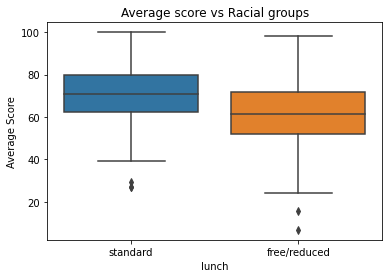

In [48]:
sb.boxplot(data = df_mod, x = "lunch", y = "avg_score");
plt.ylabel("Average Score");
plt.title("Average score vs Racial groups");

As we can see, the score differs with the type of lunch the students have, with poeple having `reduced` lunch scoring lower. This can also reflect financial status of these student's families

## Average Test Score vs the parents' level of education

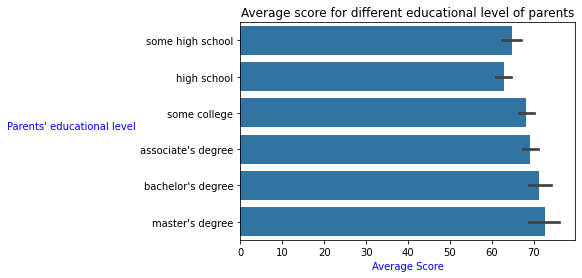

In [49]:
sb.barplot(data = df_mod, y = "parent_education", x = "avg_score", color = base_color);
plt.ylabel("Parents' educational level", rotation = 0, ha = "right", color = "Blue");
plt.xlabel("Average Score", color = "Blue");
plt.title("Average score for different educational level of parents");

It looks like the higher the educational level of the parent, the better the grade

## What is the relation between completing a preparation course, and the average score?

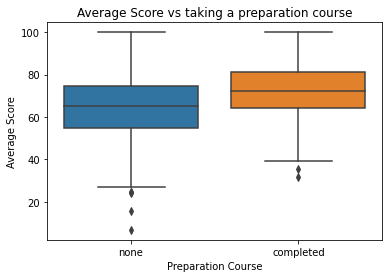

In [50]:
sb.boxplot(data = df_mod, x = "prep_course", y = "avg_score");
plt.ylabel("Average Score");
plt.xlabel("Preparation Course");
plt.title("Average Score vs taking a preparation course");

As one might expect, people completing a preparation course tend to fare better in exams

## So far, we have done bivariate analysis on every variable with the average score, and reached the following observations:
* Both genders display nearly similar performance
* Racial group E is the best performing group, whereas racial group B is the worst performing group
* Students that completed a preparation course tend to perfrom better
* Students with standard lunch meals tend to perform better than students with reduced lunch
* Students scores tend to improve with higher educaitonal levels from their parents

The effects of lunch type, preparation course, and parent's education can be summarized in the following faceted plot

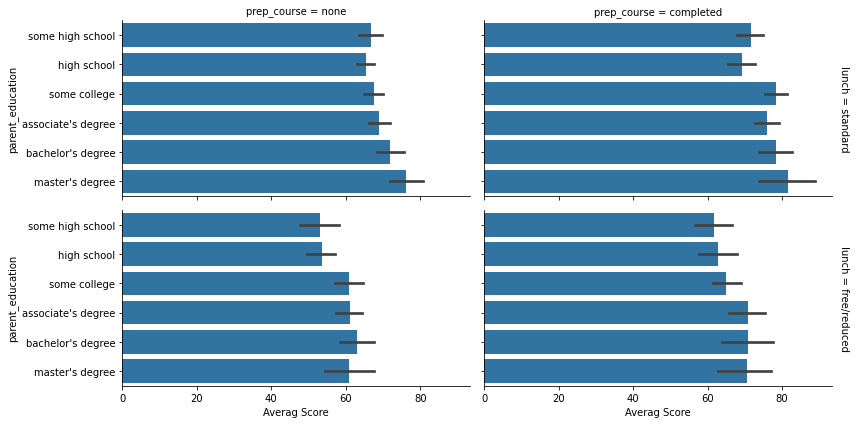

In [60]:
g = sb.FacetGrid(data = df_mod, row="lunch", col = "prep_course", height = 3,aspect=2,  margin_titles=True);
g.map(sb.barplot, "avg_score", "parent_education");
g.set_axis_labels("Averag Score");

From the plot, we can see that:
* In all 4 figures, there is a trend where the students' score increases as the parents' level of educaiton increases
* If we move from the figures in the left to the right (From not completing a preparation course to completing one), the average score increases.
* If we move from the figures in the bottom to the top (From reduced meal to standard meal), the average score increases.

## So, why do racial groups have differing performance ?
Is it inherent to the racial group itself, or is it becuase racial groups happen to have a favorable combination of previous factors?

## What kind of lunch do different racial groups have?

In [54]:
df_mod.groupby("race")["lunch"].value_counts()

race     lunch       
group A  standard         53
         free/reduced     36
group B  standard        121
         free/reduced     69
group C  standard        205
         free/reduced    114
group D  standard        167
         free/reduced     95
group E  standard         99
         free/reduced     41
Name: lunch, dtype: int64

In [55]:
# groupby lunch type, and get the value counts (it's faster to use lambdas)
grouped_race_lunch = df_mod.groupby("race")["lunch"].agg(lambda x: x.value_counts()["standard"]/x.value_counts()["free/reduced"])
grouped_race_lunch

race
group A    1.472222
group B    1.753623
group C    1.798246
group D    1.757895
group E    2.414634
Name: lunch, dtype: float64

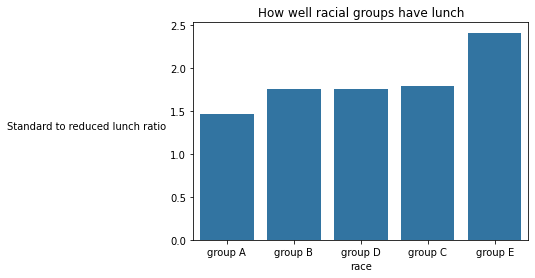

In [56]:
# get the order
ordered = grouped_race_lunch.sort_values()

# plot
sb.barplot(x = ordered.index, y = ordered.values, color = base_color);
plt.title("How well racial groups have lunch");
plt.ylabel("Standard to reduced lunch ratio", ha = "right", rotation = 0);

So, it looks like group E enjoys the best standard to reduced lunch ratio, whereas group A has the worst. This is consistent with
* The direct relationship between having standard lunch and good score
* Group E has the best average score, whereas group A has the worst score

## How do racial groups differ with completing a preparation course?

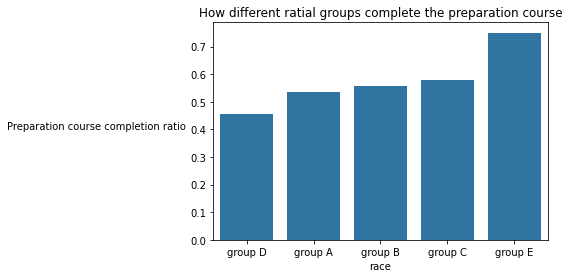

In [57]:
# groupby lunch type, and get the value counts (it's faster to use lambdas)
grouped_race_prep = df_mod.groupby("race")["prep_course"].agg(lambda x: x.value_counts()["completed"]/x.value_counts()["none"])
grouped_race_prep
ordered = grouped_race_prep.sort_values()

# plot
sb.barplot(x = ordered.index, y = ordered.values, color = base_color);
plt.ylabel("Preparation course completion ratio", rotation = 0, ha = "right");
plt.title("How different ratial groups complete the preparation course");

As we can see, group A is the second least group in completing the preparation course, whereas group E is the highest. This is consistent with our observations that
* Preparation course completion tends to improve grads
* group E is the best performing group, and the best in course completion ratio. On the opposite side is group A

## Now let's see the proportion of parental level of education for each racial group
Because racial groups have different numbers of records, we should opt to the proportion, and not the absolute count. For that, I will
* Groupby race
* For each race group, calculate the proportion of each educational level

In [58]:
# the lambda function calculates the proportions
race_grouped = df_mod.groupby("race")["parent_education"].apply(lambda x: x.value_counts()/x.count())
race_grouped.name = "proportion"

# convert to dataframe
race_grouped = race_grouped.to_frame().reset_index().rename(columns = {"level_1": "parent_education"})
race_grouped.head()

,race,parent_education,proportion
0,group A,some high school,0.269663
1,group A,some college,0.202247
2,group A,high school,0.202247
3,group A,associate's degree,0.157303
4,group A,bachelor's degree,0.134831


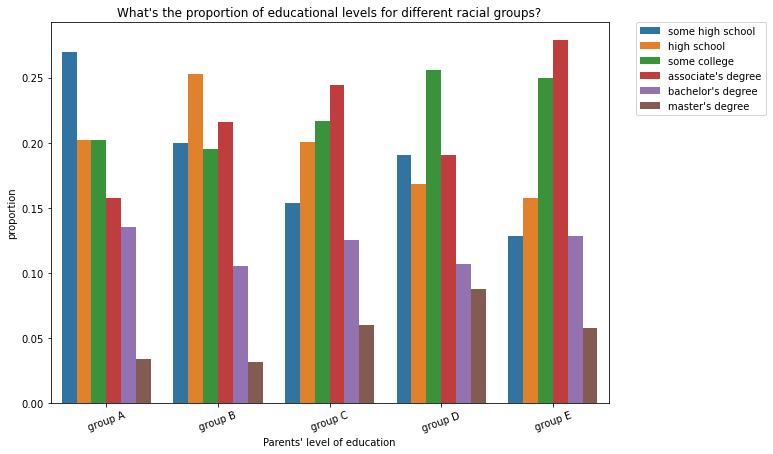

In [62]:
# now we plot
plt.figure(figsize=(10,7));
sb.barplot(data = race_grouped,y = "proportion", hue = "parent_education",x = "race");
plt.xticks(rotation = 20);
plt.xlabel("Parents' level of education");
plt.title("What's the proportion of educational levels for different racial groups?");
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

We can see that 
* For group A, the proportions are skewed towards lower educational levels
* Then we progress to group E, we find that the educational levels proportions resembel a "Gaussian", with the majority of educational levels in the college and associate's degrees

We can argue that this also is consistent with our previous findings, where
* Students whose parents have higher educational levels tend to score more
* group E has the highest score, and the most balanced among parent's educational levels
* group A is has the lowest score, and are skewed towards lower educational levels for parents.


#### As such,  we can hypothesize that the bad performance of other racial groups can be influended by:
* Parent's level of education
* Whether or not students have completed a preparatory course
* Whether or not students enjoy a standard meal or a reduced meal

That is the reason why different racial groups have different scores can be due to other factors rather than race itself. Therefore I suggest that further investigation is required, and facilities be provided for those in need, in order to offer equal opportunities to students of different racial groups.